In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import struct
from astropy.time import Time
from scipy.ndimage.filters import uniform_filter1d
%matplotlib inline

In [2]:
#Calculate number of rows for a period
period = 0.714519699726 #period
period/(2.56e-6*256) #number of rows in period, round to nearest integer

1090.2705379119873

In [3]:
#Pulsar header
pulsar_data = open("AST326_ARO_B0329+54.dat", "rb")
header_packed = pulsar_data.read(48)
header_unpacked = struct.unpack('=iiiidiiiId', header_packed)

slice_length = header_unpacked[0]
header_length = header_unpacked[1]
number_samples = header_unpacked[2]
data_type = header_unpacked[3]
cadence_raw = header_unpacked[4]
number_freqs = header_unpacked[5]
number_elems = header_unpacked[6]
spec_sum = header_unpacked[7]
handshake_index = header_unpacked[8]
handshake_utc = header_unpacked[9]

#Pulsar frequencies
header_info = pulsar_data.read(number_freqs*4*2)
freq_list = np.frombuffer(header_info[:number_freqs*4*2], dtype=np.float32)
freq_list = freq_list.reshape(-1,2)
freqs = freq_list.mean(axis=1)

#Bring data in period by period
data_list = np.zeros((119,1091,1024)) #Create an array for the data, where we will have 119 arrays of 1091 rows by 1024 frequency columns 
for i in np.arange(119): #Iterate through the number of arrays
    data_chunk = np.zeros((1091,1024)) #Create an array for each period
    for i in np.arange(1091): #Iterate through the number of rows in a period
        data_header = np.frombuffer(pulsar_data.read(header_length), dtype=np.float32) #Import header data
        index, az, alt = struct.unpack('Iff', data_header) #Import index, azimuth, altitude information
        data = np.frombuffer(pulsar_data.read(slice_length-header_length),dtype=np.float32) #Import data
        data_chunk[i] = data #Append data to period chunk
    data_list[:i] = data_chunk #Append chunks to total data array

avgs = np.mean(data_list, axis=0) #Average over the periods

#Create time data
timestep = cadence_raw*spec_sum
t = timestep*np.arange(avgs.shape[0]) #Time

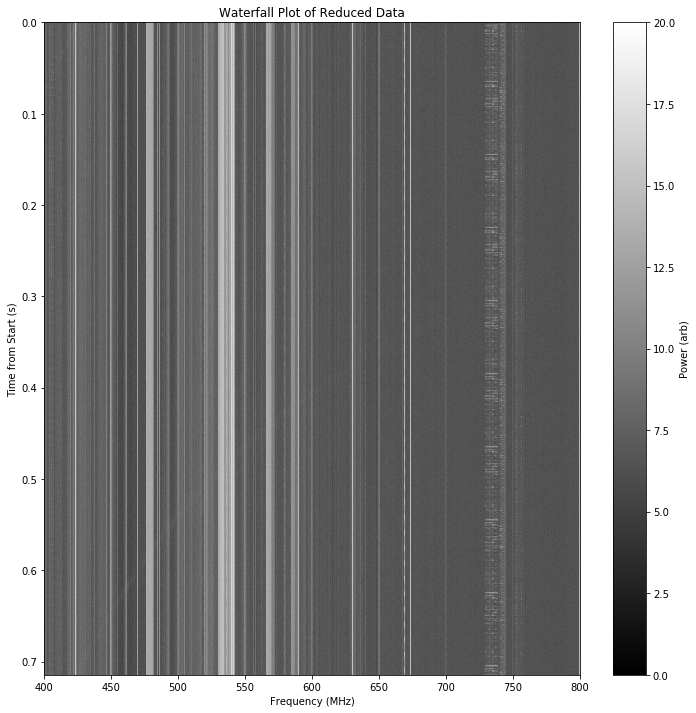

In [4]:
#Waterfall plot of averages
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(avgs),aspect="auto", extent=[400,800,np.amax(t), np.amin(t)], vmax=20, vmin=0, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Reduced Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('initial_waterfall_avg.png')

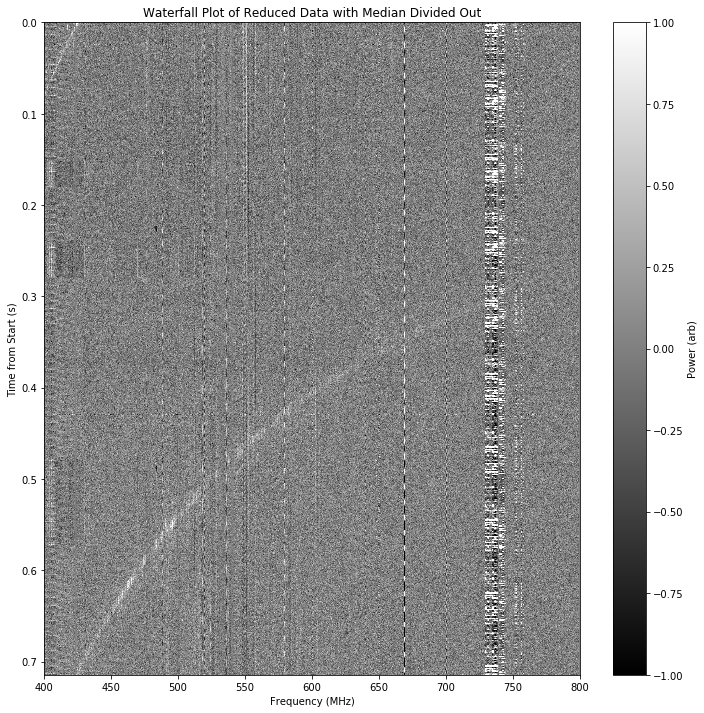

In [5]:
#Divide out median to reduce noise
median_RFI = np.median(avgs, axis=0) #Calculate median 
RFI_less = avgs/median_RFI #Divide out median

#Plot median-less data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(RFI_less), extent=[400,800,np.amax(t), np.amin(t)], aspect='auto', vmax=1, vmin=-1, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Reduced Data with Median Divided Out')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_clean_avg.pdf')

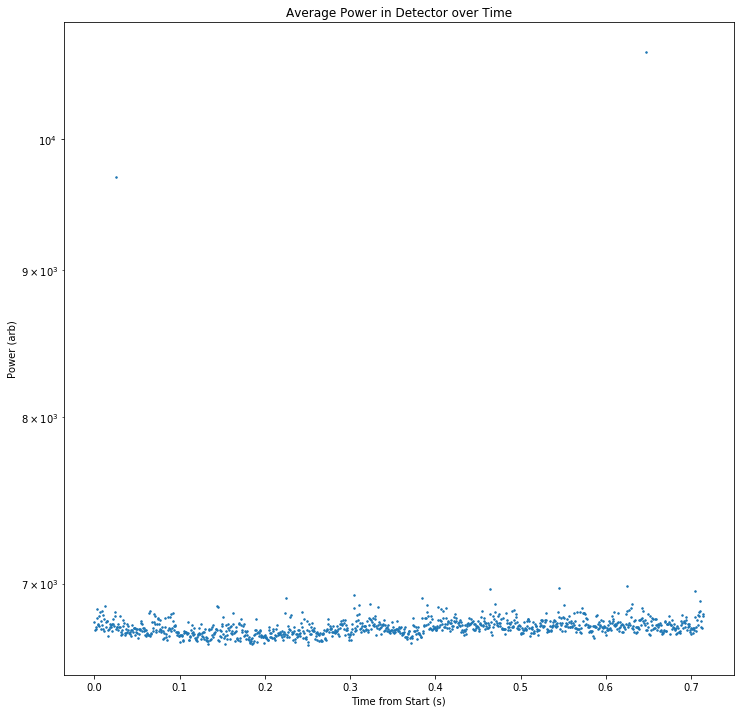

In [6]:
#Cut out RFI
avgs_sum = np.sum(avgs, axis=1) #Sum over the frequencies

#Plot this to find the RFI
plt.figure(figsize=(12,12))
plt.plot(t, avgs_sum, ls='', marker = 'o', markersize = 1.5)
plt.semilogy()
plt.xlabel('Time from Start (s)')
plt.ylabel('Power (arb)')
plt.title('Average Power in Detector over Time')
plt.savefig('RFI_avg.pdf')

#Define where the RFI is
large_values = np.where(avgs_sum > 8000)
period = 0.714519699726 #period

#Cut RFI
RFI_noise = large_values[0].tolist()
RFI_noise.append([0])
for i in np.arange(avgs.shape[0]):
    if i == RFI_noise[0]:
        RFI_noise.pop(0)
        continue

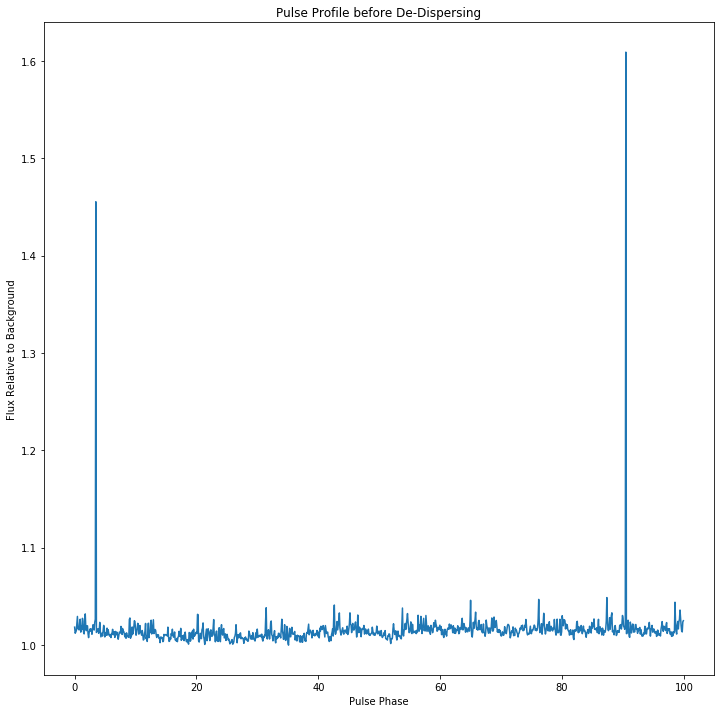

In [7]:
#Plot profile before de-dispersing
profile_dispersed = np.sum(avgs, axis=1)

#Normalize
normal_profile_dispersed = profile_dispersed/np.min(profile_dispersed)

#Plot
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/1091),normal_profile_dispersed)
plt.title('Pulse Profile before De-Dispersing')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
plt.savefig('pulse_profile_dispersed_avg.pdf')

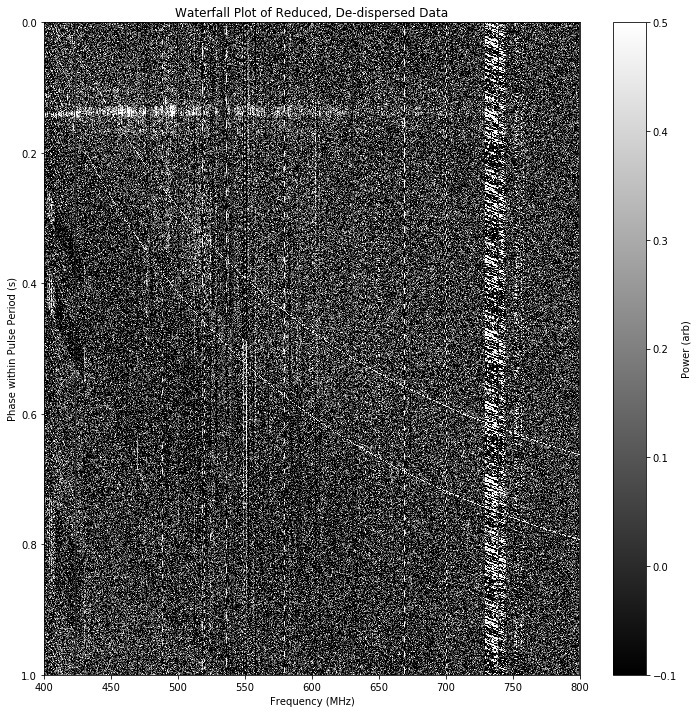

In [8]:
#De-disperse
freq_number=1024
k = 4.15e-3 #Dispersion measure time prefactor
dm = 26.7641 #Dispersion measure
dispersion = (k*dm*(freqs/1000)**-2) #Calculate the dispersion
dm_array = np.zeros((1091,1024)) #Create an empty array to append the de-dispersion data to
for i in np.arange(freq_number): #Iterate through the length of the frequencies
    dm_array[:,i] = np.roll(avgs[:,i], -int(dispersion[i]/period*1091)) #Roll the data over the period to de-disperse 
                                                                        #and make the pulse straight across the 
                                                                        #frequency band

#Divide the median out to reduce noise
dedispersed_data = dm_array/np.median(dm_array, axis=0)

#Plot
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_data), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', \
           vmin = -.1, vmax = .5, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of Reduced, De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_dedispersed_avg.pdf')

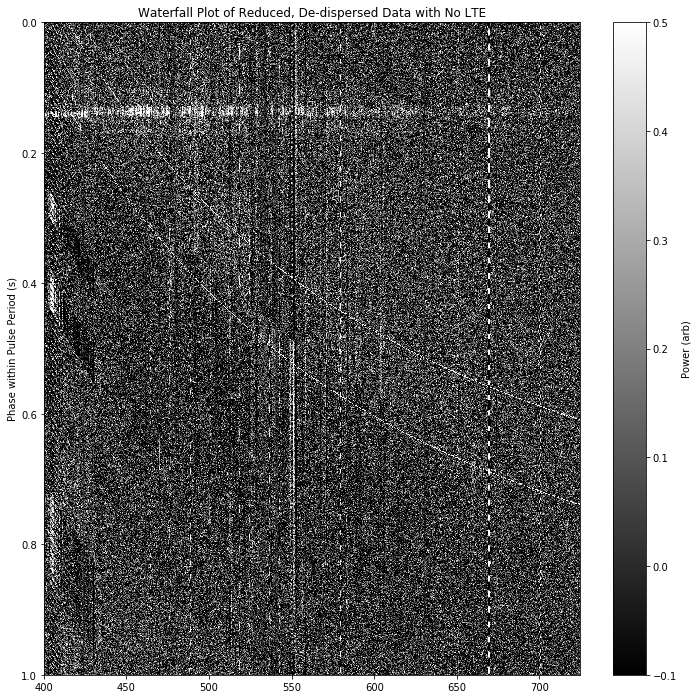

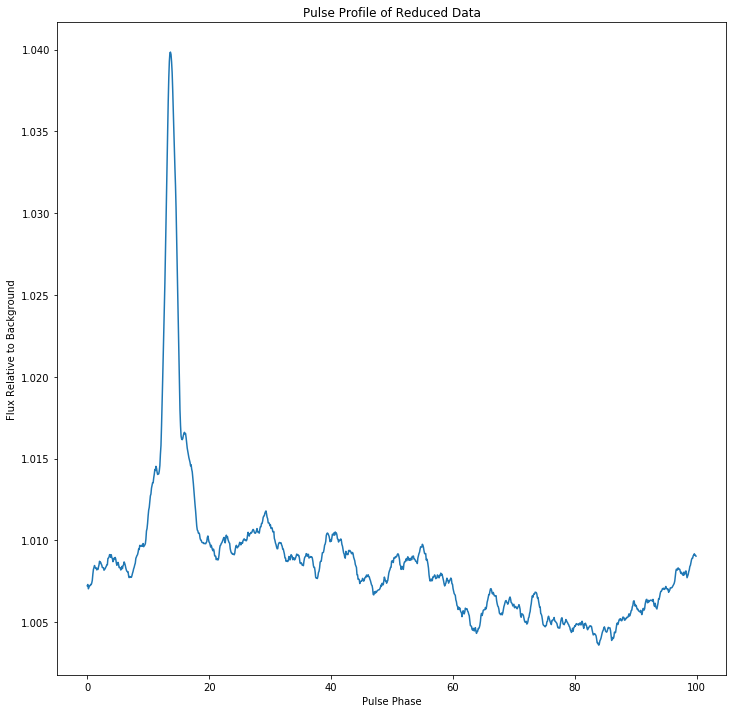

In [9]:
#Cut out the LTE band
LTE_less = [] #Create empty list to append data before LTE to
temp_list = [] #Create holding list
for i in np.arange(0,1091): #Iterate through the rows
    temp_list = list(dedispersed_data[i][0:830]) #Put the data up to LTE in the holding list
    LTE_less.extend(temp_list) #Put the data into the LTE_less list
LTE_less_array = np.array(LTE_less) #Turn the list into an array
LTE_reshaped = LTE_less_array.reshape(1091,830) #Reshape the array so in proper period rows

#Plot
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, \
           vmax = .5, cmap='gray')
plt.title('De-dispersed Data with LTE Band Excised')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of Reduced, De-dispersed Data with No LTE')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_dedispersed_noLTE_avg.png')

#Calculate the pulse profile
profile = np.sum(LTE_reshaped, axis=1)

#Normalize
normal_profile = profile/np.min(profile)

#Smooth
smooth_profile = uniform_filter1d(normal_profile, 20)

#Plot the pulse profile
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/1091),smooth_profile)
plt.title('Pulse Profile of Reduced Data')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background') 
plt.savefig('smoothed_profile_avg.png')

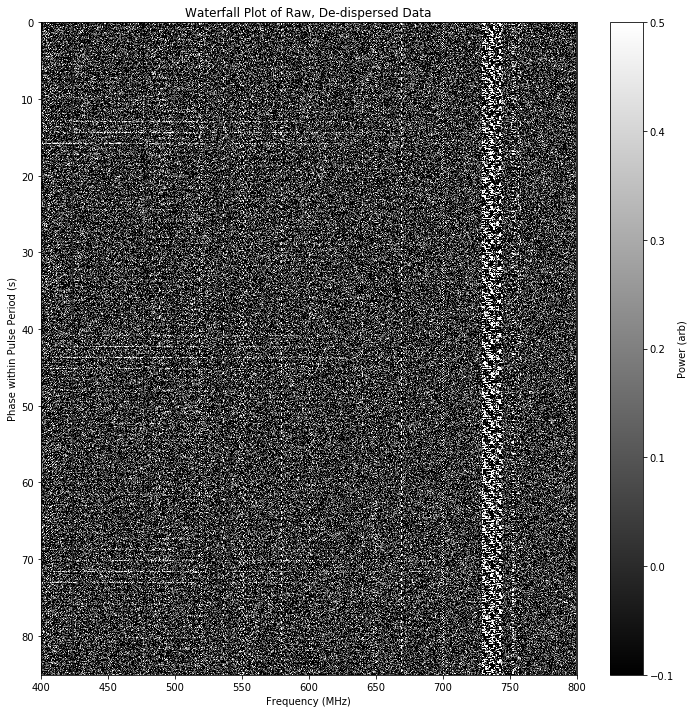

In [10]:
#De-disperse raw dataset
raw_dat = data_list.reshape(129829,1024) #Put data into one array
t_raw = timestep*np.arange(raw_dat.shape[0]) #Calculate new time axis (~85 seconds)
k = 4.15e-3 #Dispersion measure time prefactor
dm = 26.7641 #Dispersion measure
dispersion = (k*dm*(freqs/1000)**-2) #Calculate the dispersion
dm_array = np.zeros((129829,1024)) #Create empty array for de-dispersed data
for i in np.arange(freq_number):
    dm_array[:,i] = np.roll(raw_dat[:,i], -int(dispersion[i]/timestep)) #Roll over the timestep
    
#Divide out the median to reduce noise
dedispersed_raw_data = dm_array/np.median(dm_array, axis=0)

#Plot raw, de-dispersed data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_raw_data), extent = [np.amin(freqs), np.amax(freqs), np.amax(t_raw), \
                                                        np.amin(t_raw)], aspect = 'auto', vmin = -.1, vmax = .5, \
           cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of Raw, De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_dedispersed_raw_avg.pdf')

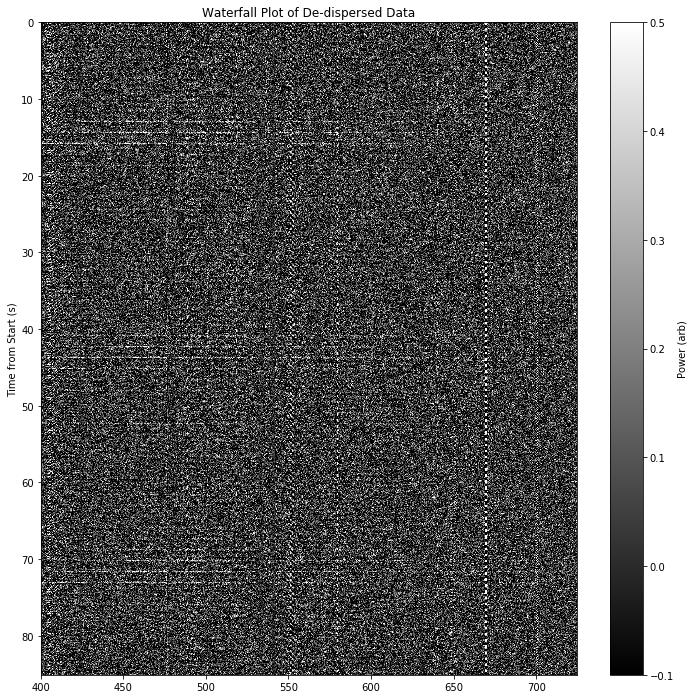

In [11]:
#Remove LTE using the same routine as above
LTE_less_raw = []
temp_list_raw = []
for i in np.arange(0,129829):
    temp_list_raw = list(dedispersed_raw_data[i][0:830])
    LTE_less_raw.extend(temp_list_raw)
LTE_raw_array = np.array(LTE_less_raw)
LTE_raw_reshaped = LTE_raw_array.reshape(-1,830)

#Plot
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_raw_reshaped), extent = [np.amin(freqs), 724.41406, np.amax(t_raw), np.amin(t_raw)], \
           aspect = 'auto', vmin = -.1, vmax = .5, cmap='gray')
plt.title('De-dispersed Raw Data with LTE Band Excised')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of De-dispersed Data')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('dedispersed_raw_noLTE_avg.pdf')

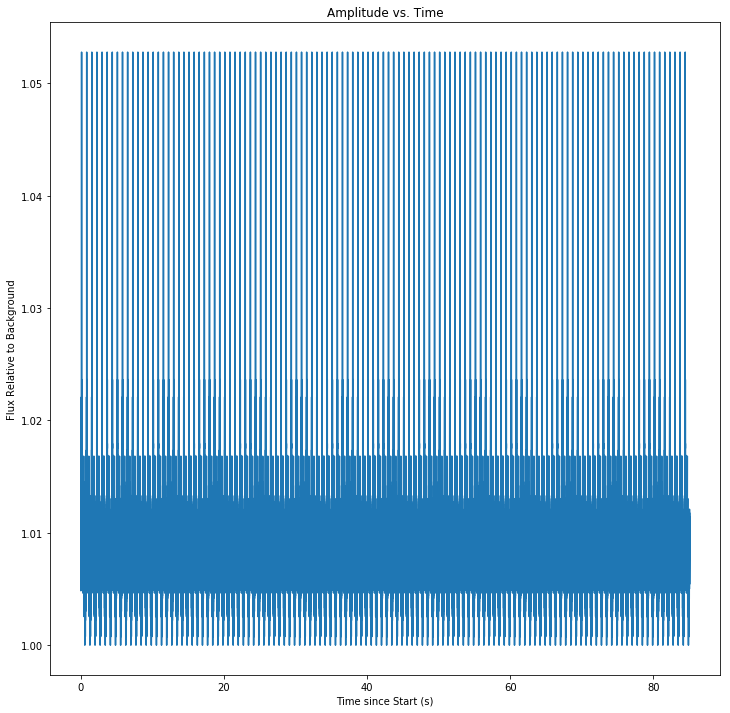

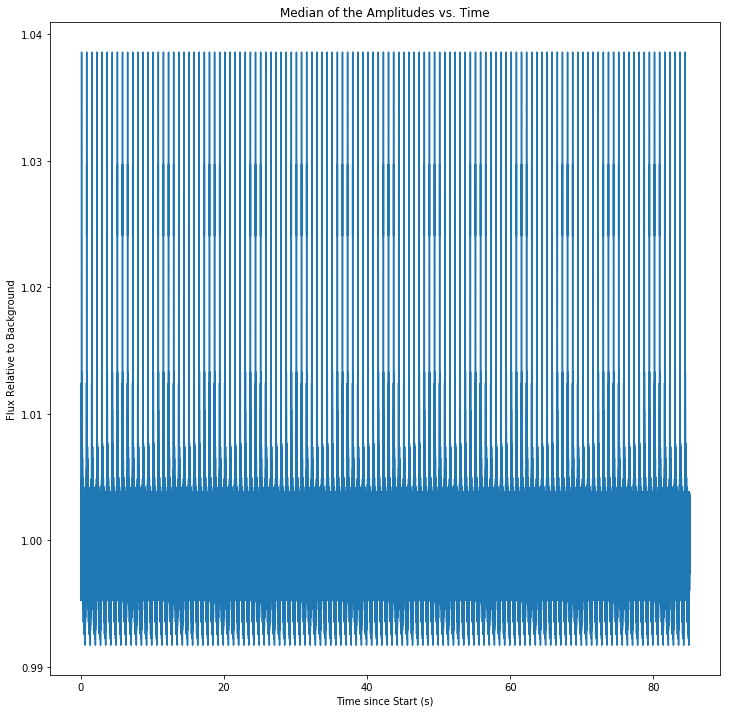

In [12]:
#How pulse amplitudes vary in time
amplitude_data = np.sum(LTE_raw_reshaped, axis=1) #Sum over the frequency axis
normal_amplitude = amplitude_data/np.min(amplitude_data) #Normalize
#Calculate the median, will give less noisy result
amplitude_median = np.median(LTE_raw_reshaped, axis=1)

#Plot the normalized amplitude
plt.figure(figsize=(12,12))
plt.plot(t_raw, normal_amplitude)
plt.title('Amplitude vs. Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Flux Relative to Background')
plt.savefig('amplitude_time_avg.pdf')

#Plot the amplitude median
plt.figure(figsize=(12,12))
plt.plot(t_raw, amplitude_median) #This plot is less noisy
plt.title('Median of the Amplitudes vs. Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Flux Relative to Background')
plt.savefig('amplitude_median_avg.pdf')

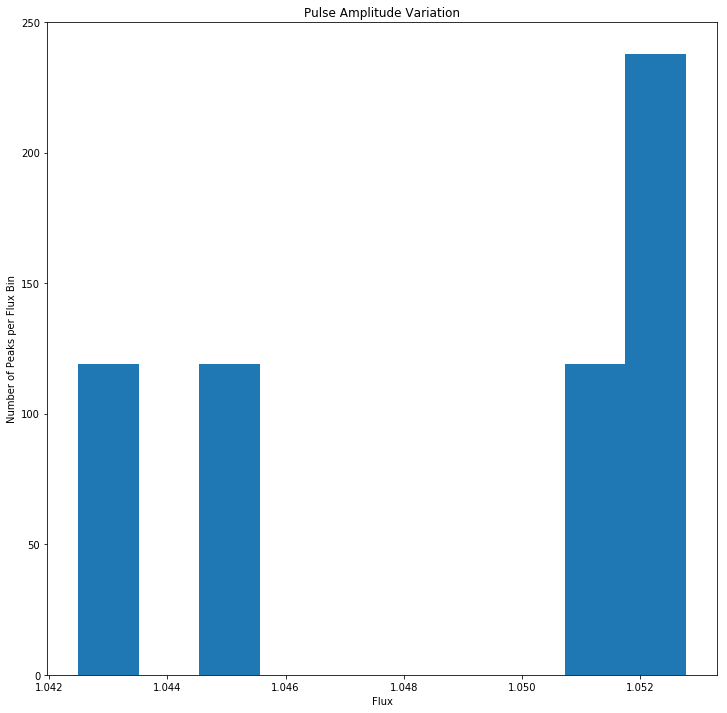

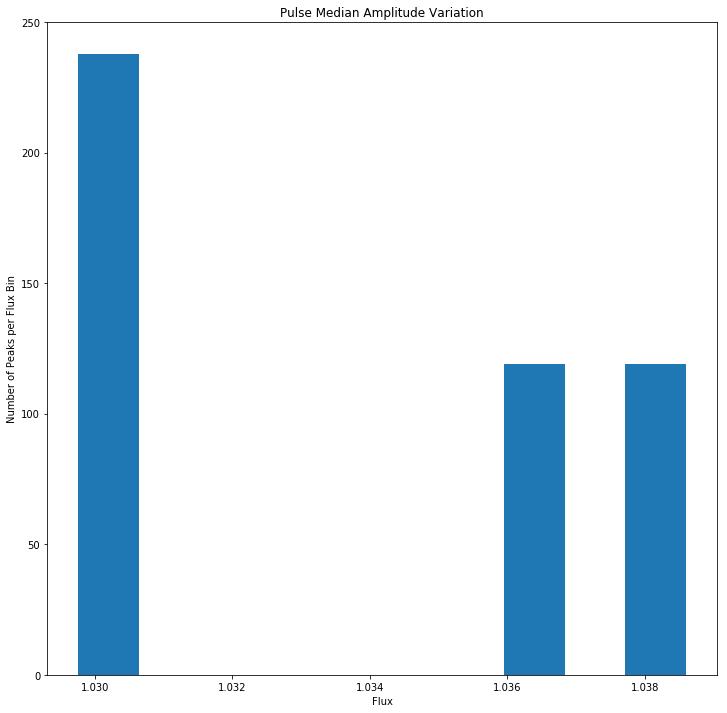

In [13]:
#Find the peaks using Andy's telescope peak finding function: 
def centfindert(x, threshold,threshold2): #Choose thresholds
    pixels = np.arange(0,len(x))
    intensity = x
    peaksx = [] #This is the values that the peaks are centred around
    peaksy = []
    peak_dex = (list(intensity))
    inversep_dex=intensity[::-1]
    for i in range(len(intensity)-1):
        if intensity[i] > threshold and intensity[i-1] <intensity[i] and intensity[i+1] < intensity[i]:
            peaksx.append(pixels[i])
            peaksy.append(intensity[i])
    peaksx = np.array(peaksx)
    peaksy = np.array(peaksy)
    return peaksy

#Calculate the peaks of the amplitude
amplitude_peaks = centfindert(normal_amplitude, 1.03,1.03)

#Plot a histogram of the peaks
plt.figure(figsize=(12,12))
plt.hist(amplitude_peaks)
plt.title('Pulse Amplitude Variation')
plt.xlabel('Flux')
plt.ylabel('Number of Peaks per Flux Bin')
plt.savefig('amplitude_hist_avg.pdf')

#Calculate the peaks of the median amplitudes
amplitude_median_peaks = centfindert(amplitude_median, 1.02, 1.02) 

#Plot a histogram of the median peaks
plt.figure(figsize=(12,12))
plt.hist(amplitude_median_peaks)
plt.title('Pulse Median Amplitude Variation')
plt.xlabel('Flux')
plt.ylabel('Number of Peaks per Flux Bin')
plt.savefig('amplitude_median_hist_avg.pdf')

In [14]:
#Rebin timeseries data for convolution
phase_bins = period/1091 #Divide the period by the number of bins
timeseries_bins = phase_bins/timestep #Divide the phase bins by the timestep
print(timeseries_bins)
amplitude_reshaped = normal_amplitude.reshape(-1,1) #Reshape the amplitude data accordingly
amplitude_rebinned = np.mean(amplitude_reshaped, axis=1) #Take the mean

#Pad the average pulse profile with zeros to make it the same size as the timeseries data
padded_profile = np.zeros(129829)
for i in range(0,500):
    padded_profile[i] = normal_profile[i]

0.999331382137477


Text(0,0.5,'Flux Relative to Background')

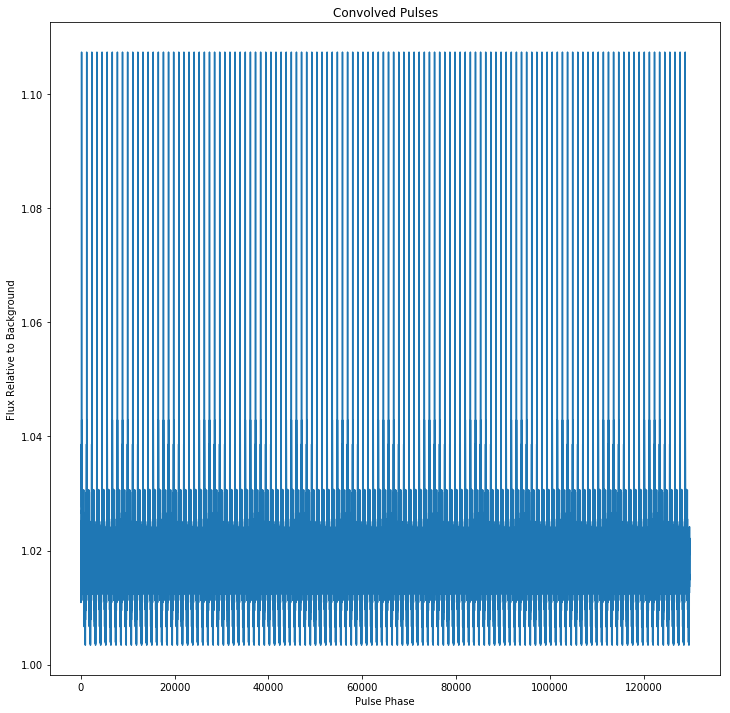

In [15]:
#Convolve the timeseries within the average pulse profile
convolution = np.zeros_like(padded_profile) #Create an empty array for the convolved data
for i in range(len(amplitude_rebinned)): #Iterate through the length of the rebinned data
    convolution = padded_profile*amplitude_rebinned #Convolve the data
    padded_profile = np.roll(amplitude_rebinned, 1, axis=0) #Roll through to convolve each peak
    
#Plot the convolved data
plt.figure(figsize=(12,12))
plt.plot(convolution)
plt.title('Convolved Pulses')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
#plt.savefig('convolution_avg.pdf')

(20, 40)

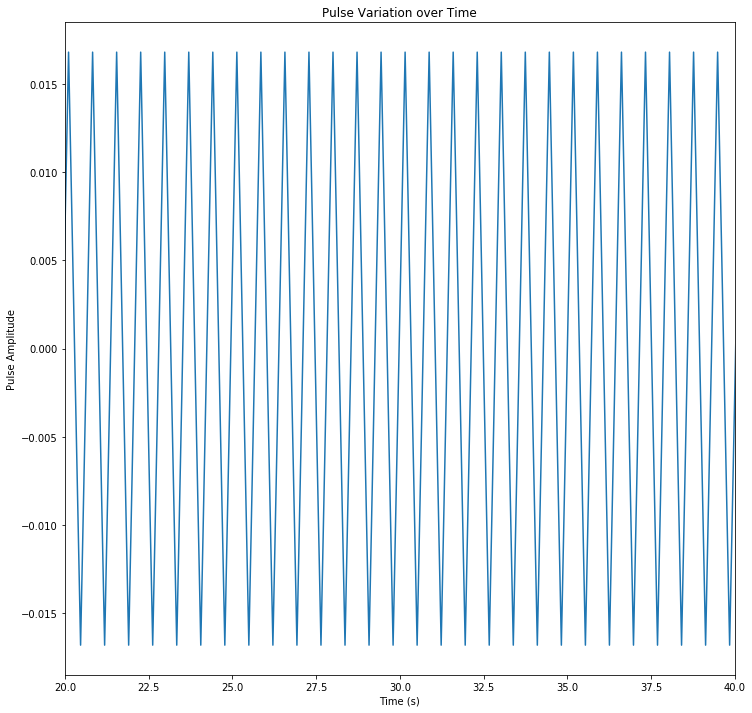

In [17]:
#Find the peaks of the convolved timestream using Andy's telescope peak finding function: 
convolved_peaks = centfindert(convolution, 1.05,1.05)

#Take difference between each subsequent pulse
peak_difference = np.zeros(237) #Make array of zeros the length of convolved_peaks - 1
for i in range(len(convolved_peaks)-1):
    peak_difference[i] = convolved_peaks[i + 1] - convolved_peaks[i]

#Plot these differences to see the variation in pulses over time
plt.figure(figsize=(12,12))
plt.plot(np.arange(np.amin(t_raw), np.amax(t_raw), (np.amax(t_raw) - np.amin(t_raw))/len(peak_difference)), \
         peak_difference)
plt.title('Pulse Variation over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pulse Amplitude')
#plt.savefig('peak_difference_var_avg.pdf')
plt.xlim(20,40)

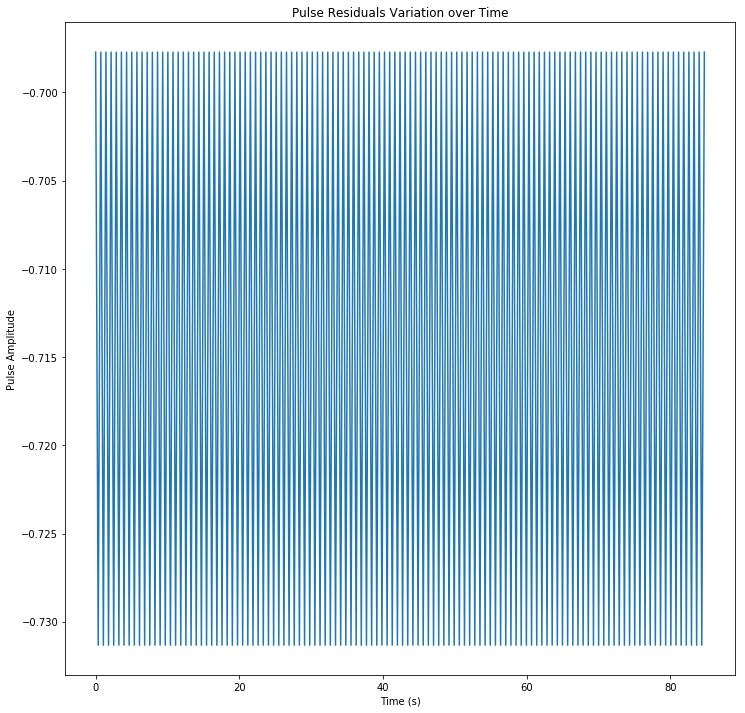

In [25]:
#Calculate the residuals instead, can also see pulse variation here
peak_residuals = peak_difference - period

#Plot the residuals
plt.figure(figsize=(12,12))
plt.plot(np.arange(np.amin(t_raw), np.amax(t_raw), (np.amax(t_raw) - np.amin(t_raw))/len(peak_residuals)), \
         peak_residuals)
plt.title('Pulse Residuals Variation over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pulse Amplitude')
plt.savefig('peak_residual_var_avg.pdf')